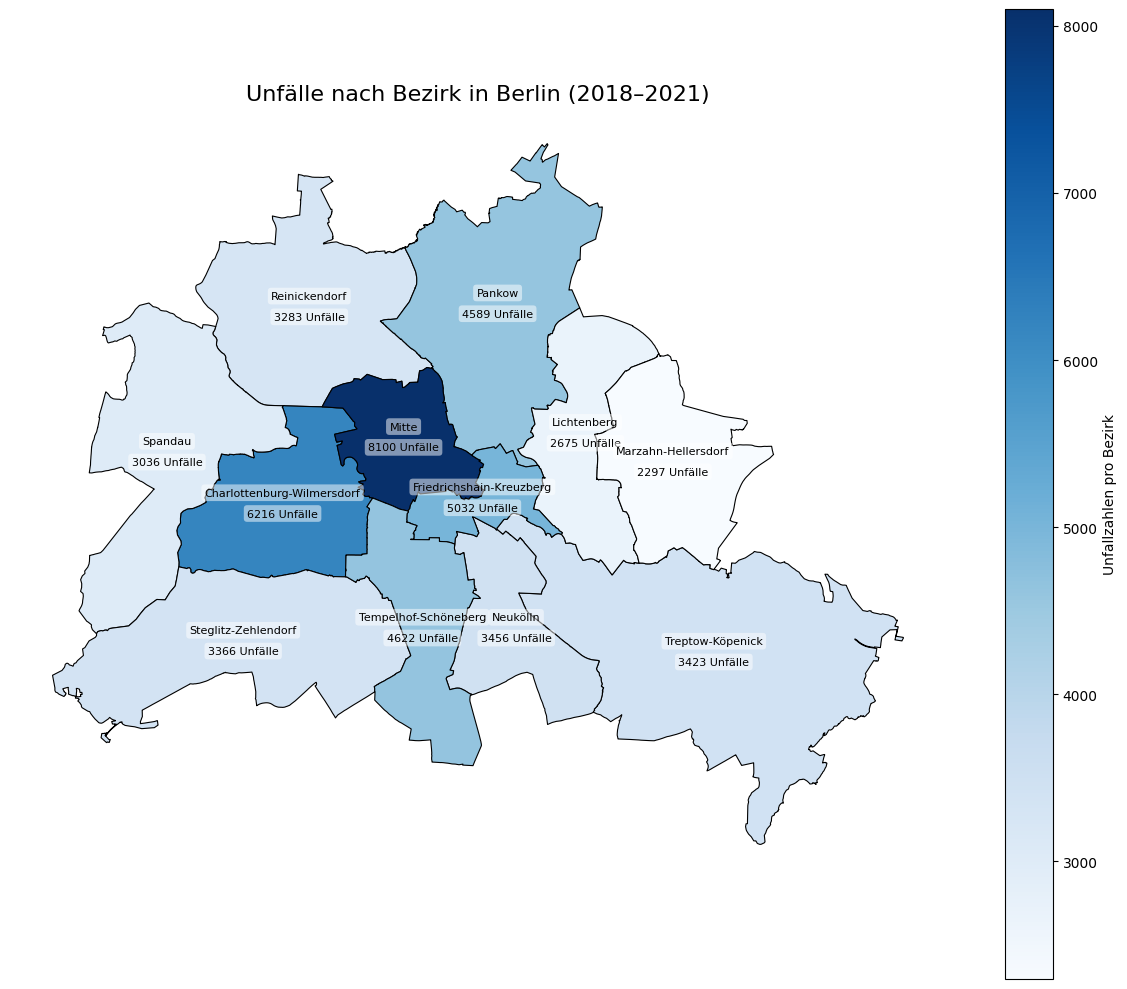

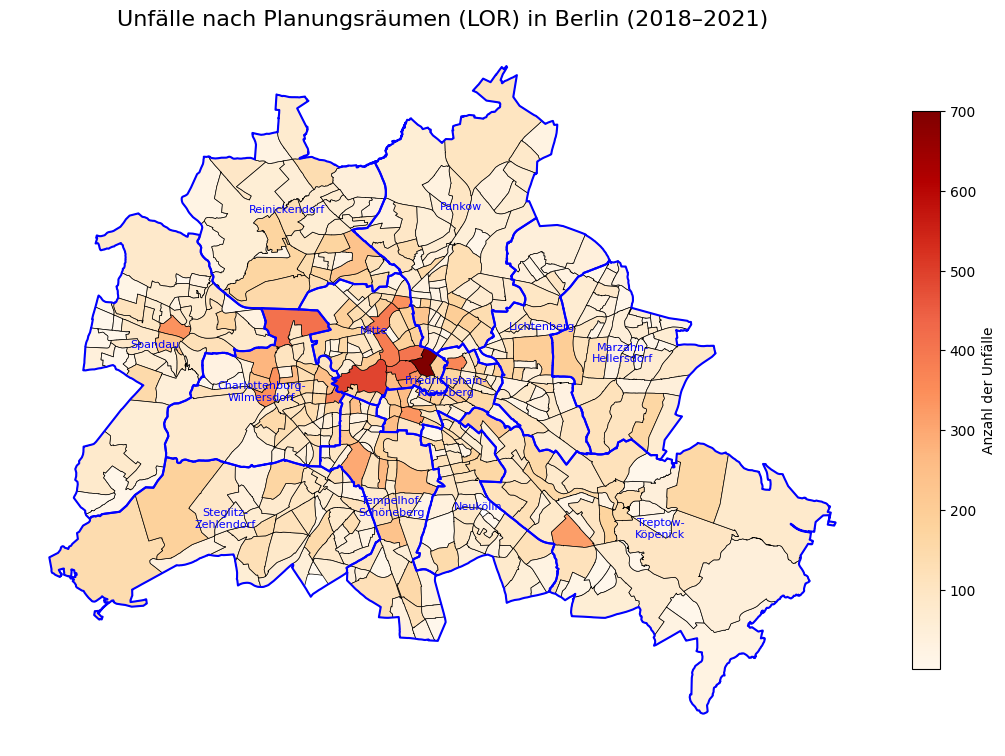

In [17]:
##############################
# BENÖTIGTE BIBLIOTHEKEN
##############################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
from adjustText import adjust_text
import textwrap
import folium
from folium.plugins import HeatMap
from sklearn.decomposition import PCA

##############################
# DATEN EINLESEN
##############################

# Unfalldaten laden
file = "bereinigte_daten.csv"
filtered_data2 = pd.read_csv(file)

# Geodaten der LOR-Planungsräume laden (GeoJSON)
lor_geo = gpd.read_file("lor_planungsraeume_2021.geojson")

##############################
# VISUALISIERUNG 1: Unfälle pro Bezirk (mit Bezirksnamen & Werten)
##############################

# Gruppierung: Unfälle pro LOR
lor_unfaelle = filtered_data2.groupby('LOR_ab_2021').size().reset_index(name='Anzahl_Unfaelle')

# Hinweis: Die Variable 'districts' muss ein GeoDataFrame mit Bezirksgrenzen und Spalten 'Gemeinde_name' & 'Anzahl_Unfaelle' sein

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Bezirke einfärben nach Anzahl der Unfälle
districts.plot(
    column='Anzahl_Unfaelle',
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Unfallzahlen pro Bezirk", 'orientation': "vertical"}
)

# Bezirksnamen und Unfallzahlen einfügen
for _, row in districts.iterrows():
    # Name leicht oberhalb
    plt.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y + 0.005,
        f"{row['Gemeinde_name']}",
        ha='center',
        fontsize=8,
        color='black',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3')
    )
    # Unfallzahl leicht unterhalb
    plt.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y - 0.005,
        f"{int(row['Anzahl_Unfaelle'])} Unfälle",
        ha='center',
        fontsize=8,
        color='black',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3')
    )

# Formatierung der Karte
ax.set_title("Unfälle nach Bezirk in Berlin (2018–2021)", fontsize=16)
ax.axis('off')
plt.tight_layout()

# Speichern
plt.savefig("output/plots/Unfallzahlen_nach_Bezirken.png", dpi=100)
plt.show()

##############################
# VISUALISIERUNG 2: Unfälle pro LOR mit Bezirksgrenzen
##############################

# LOR-Geometrien umprojizieren (EPSG:4326 für Folium-Kompatibilität)
lor_geo = lor_geo.to_crs("EPSG:4326")

# ID-Spalten als String formatieren, führende Nullen ergänzen (vereinheitlicht für Merge)
lor_geo['PLR_ID'] = lor_geo['PLR_ID'].astype(str).str.zfill(8)
lor_unfaelle['LOR_ab_2021'] = lor_unfaelle['LOR_ab_2021'].astype(str).str.zfill(8)

# Verknüpfen: Unfalldaten an Geo-Daten anhängen
lor_geo = lor_geo.merge(lor_unfaelle, left_on='PLR_ID', right_on='LOR_ab_2021', how='right')

# Fehlende Werte mit Null ersetzen
lor_geo['Anzahl_Unfaelle'] = lor_geo['Anzahl_Unfaelle'].fillna(0)

# Karte zeichnen
fig, ax = plt.subplots(figsize=(12, 12))

# LOR-Flächen einfärben
lor_geo.plot(
    column='Anzahl_Unfaelle',
    cmap='OrRd',
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

# Bezirksgrenzen hinzufügen
districts.boundary.plot(ax=ax, color='blue', linewidth=1.5, label="Bezirksgrenzen")

# Bezirksnamen über Mittelpunkt eintragen (Zeilenumbruch für lange Namen)
for idx, row in districts.iterrows():
    centroid = row.geometry.centroid
    bezirk_name = "\n".join(textwrap.wrap(row['Gemeinde_name'], 15))  # z.B. "Charlottenburg-\nWilmersdorf"
    ax.text(
        centroid.x, centroid.y + 0.005, bezirk_name,
        fontsize=8, color='blue', ha='center', va='center'
    )

# Farbskala konfigurieren (klein & platzsparend)
sm = plt.cm.ScalarMappable(
    cmap='OrRd',
    norm=plt.Normalize(vmin=lor_geo['Anzahl_Unfaelle'].min(), vmax=lor_geo['Anzahl_Unfaelle'].max())
)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Anzahl der Unfälle")

# Titel & Layout
ax.set_title("Unfälle nach Planungsräumen (LOR) in Berlin (2018–2021)", fontsize=16)
ax.axis('off')

# Speichern
plt.savefig("output/plots/Unfallzahlen_nach_LOR_mit_Bezirksgrenzen.png", dpi=100, bbox_inches='tight')
plt.show()
